# <a href="https://thetahat.ru/courses/ad">Введение в анализ данных</a>

## Логистическая регрессия

В этом ноутбуке мы рассмотрим пример построения модели логистической регрессии для бинарной классификации и предварительной обработки данных. Логистическая регрессия является одним из методов классификации и используется для предсказания категориальных исходов.



In [1]:
from typing import Any, List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

sns.set(font_scale=1.2, palette="Set2")
RANDOM_STATE = 42  # фиксируем зерно случайности
pd.set_option("future.no_silent_downcasting", True)
pd.options.mode.chained_assignment = None

### 1. Логистическая регрессия на искусственных данных

Рассмотрим искусственные данные с бинарным признаком из `sklearn.datasets`

#### 1.1 Один признак

In [2]:
def visualize_data(X: np.ndarray, y: Union[np.ndarray, list]) -> None:
    """Визуализирует данные на основе числа признаков в матрице X.

    Если X имеет один признак (n_features = 1), отображается гистограмма для каждого класса.
    Если X имеет два признака (n_features = 2), отображается scatter plot для каждого класса.

    Параметры:
    X (np.ndarray): Двумерный массив признаков данных. Размерность (n_samples, n_features).
    y (Union[np.ndarray, list]): Вектор меток классов данных. Размерность (n_samples,).
    """

    # Определяем число признаков
    n_features = X.shape[1]

    plt.figure(figsize=(8, 5))

    if n_features == 1:
        # Гистограмма для данных с одним признаком
        plt.hist(X[y == 0], bins=12, alpha=0.6, label="Класс 0")
        plt.hist(X[y == 1], bins=12, alpha=0.6, label="Класс 1")
        plt.xlabel("Значение признака")
        plt.ylabel("Количество элементов")
        plt.title("Распределение синтетических данных по классам")

    elif n_features == 2:
        # Точечная диаграмма для данных с двумя признаками
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], s=70, alpha=0.5, label="Класс 0")
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], s=70, alpha=0.5, label="Класс 1")
        plt.xlabel("Признак 1")
        plt.ylabel("Признак 2")
        plt.title("Синтетические данные для бинарной классификации")

    else:
        raise ValueError("Функция поддерживает только 1 или 2 признака для визуализации.")

    plt.legend()
    plt.show()

In [3]:
def generate_data(n_samples):
    """
    Генерирует выборку из двух нормальных распределений и возвращает их вместе с метками.

    Параметры:
    n_samples (int): Общее количество элементов в выборке. Количество примеров каждого класса
                     будет равно половине от n_samples.

    Возвращает:
    X (ndarray): Массив данных с признаками. Имеет форму (n_samples, 1).
    y (ndarray): Массив меток классов. Содержит 0 для первого класса и 1 для второго.
    """

    
    # Генерация данных для первого класса (X0, y0)
    X0 = np.random.normal(3, 2, int(n_samples / 2))
    y0 = np.zeros(X0.shape[0])

    # Генерация данных для второго класса (X1, y1)
    X1 = np.random.normal(8, 2, int(n_samples / 2))
    y1 = np.ones(X1.shape[0])

    # Объединение данных и меток
    X = np.hstack((X0, X1)).reshape(-1, 1)
    y = np.concatenate((y0, y1))

    return X, y

Сгенерируем искусственные данные.

In [4]:
n_samples = 300  # Размер выборки
X, y = generate_data(n_samples)

Визуализируем распределение значений в классах.

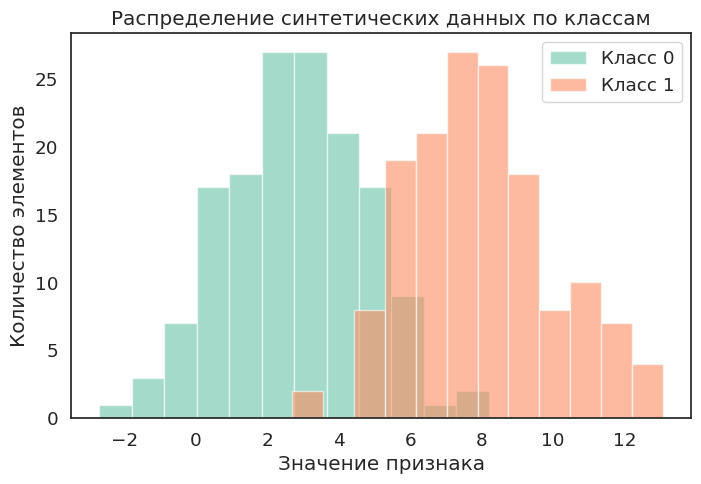

In [5]:
with sns.axes_style("white"):
    visualize_data(X, y)

Теперь обучим модель **логистической регрессии** с помощью класса <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">`LogisticRegression`</a>.

Давайте рассмотрим, как работают методы `fit`, `predict` и `predict_proba` для логистической регрессии в случае бинарной классификации

---
>**Важные аргументы конструктора:**
>* `fit_intercept` &mdash; нужно ли включать в модель свободный член. В случае `fit_intercept=True` модели не нужно передавать признак из всех единиц для того, чтобы она оценивала свободный член. По умолчанию `fit_intercept=True`.
>* `solver` &mdash; метод оптимизации для поиска оценки коэффициентов. По умолчанию `solver="lbfgs"`.
>* `max_iter` &mdash; количество итераций метода оптимизации. По умолчанию `max_iter=100`.
>* Есть также важные параметры регуляризации `penalty` и `C`, но про них мы будем говорить на 3 курсе.
>
> **Основные методы класса:**
> 
> - **метод `fit`**
> 
>     Метод `fit(X, y)` оценивает оптимальные значения параметров модели $\theta$, численно решая следующую задачу оптимизации:
>
>     $$
\min_{\theta} \sum_{i=1}^{n} \left[ - Y_i \log\left(\sigma(x_i^T \theta)\right) - (1-Y_i) \log\left(1-\sigma(x_i^T \theta)\right) \right]
$$
>
>     где $\sigma(z)$ — логистическая сигмоида, которая преобразует линейную комбинацию признаков в вероятность:
>     $$
\sigma(z) = \frac{1}{1 + \exp(-z)}
$$
> 
> 
> * **метод `predict_proba`**
> 
>     Метод `predict_proba(X)` оценивает вероятности принадлежности к классу 1 по формуле:
>
>     $$
\widehat{p}({x}) = \sigma\left(x^T \widehat{\theta}\right) = \frac{1}{1 + \exp\left(-x^T \widehat{\theta}\right)}
$$
>      Для каждого объекта из `X` возвращает два числа &mdash; оценки вероятностей классов 0 и 1. Важно помнить, что они не являются истинными вероятностями, это только *оценки* вероятностей.
>
> 
> * **метод `predict`**
> 
>     Метод `predict(X)` переводит эти оценки вероятностей, полученные методом `predict_proba(X)`, в бинарные классы («0» или «1») с использованием порога, обычно равного 0.5. То есть:
>
>     $$
\widehat{y}(x) =
\begin{cases}
1, & \text{если } \widehat{p}(x) \geq 0.5 \\
0, & \text{если } \widehat{p}(x) < 0.5
\end{cases}
$$
> 
>     Эти шаги позволяют логистической регрессии моделировать вероятность принадлежности к определенному классу и принимать решение о классификации на этом основании.



In [6]:
# Логистическая регрессия
model = LogisticRegression()
model.fit(X, y)

# Предсказание вероятностей
X_range = np.linspace(X.min() - 1, X.max() + 1, 500).reshape(-1, 1)
probabilities = model.predict_proba(X_range)[:, 1]

Визуализируем полученные вероятности.

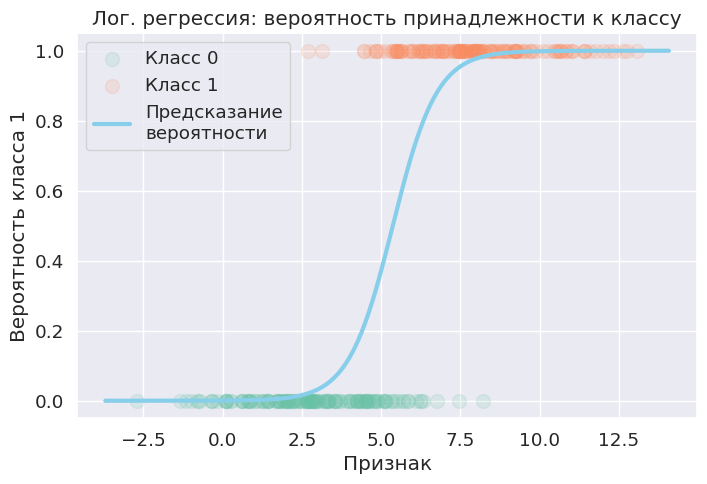

In [7]:
plt.figure(figsize=(8, 5))
plt.scatter(X[y == 0], np.zeros_like(X[y == 0]), s=100, label="Класс 0", alpha=0.15)
plt.scatter(X[y == 1], np.ones_like(X[y == 1]), s=100, label="Класс 1", alpha=0.15)
plt.plot(X_range, probabilities, label="Предсказание\nвероятности", c="skyblue", linewidth=3)
plt.title("Лог. регрессия: вероятность принадлежности к классу")
plt.xlabel("Признак")
plt.ylabel("Вероятность класса 1")
plt.legend()
plt.show()

#### 1.2 Два признака

In [8]:
def generate_intersecting_data(
    n_samples: int = 100,
    mean1: List[float] = [0, 0],
    mean2: List[float] = [2, 2],
    cov: List[List[float]] = [[1.5, 0.5], [0.5, 1.5]],
    random_state: Optional[int] = RANDOM_STATE,
) -> Tuple[np.ndarray, np.ndarray]:
    """Генерирует перекрывающиеся двумерные данные для двух классов с
    использованием многомерного нормального распределения.

    Параметры:
    n_samples (int): Общее количество объектов для генерации.
    mean1 (List[float]): Матожидание для функции распределения класса 0.
    mean2 (List[float]): Матожидание для функции распределения класса 1.
    cov (List[List[float]]): Ковариационная матрица для обоих классов.
    random_state (Optional[int]): Сеемя для генератора случайных чисел (по умолчанию None).

    Возвращает:
    Tuple[np.ndarray, np.ndarray]: Кортеж из двух массивов numpy: данные и метки классов.
    """


    rng = np.random.default_rng(random_state)
    # Генерация данных для класса 0
    X0 = rng.multivariate_normal(mean1, cov, int(n_samples / 2))
    y0 = np.zeros(X0.shape[0])

    # Генерация данных для класса 1
    X1 = rng.multivariate_normal(mean2, cov, int(n_samples / 2))
    y1 = np.ones(X1.shape[0])

    # Объединение данных обоих классов
    X = np.vstack((X0, X1))
    y = np.concatenate((y0, y1))

    return X, y

Рассмотрим данные с двумя признаками и визуализируем их.

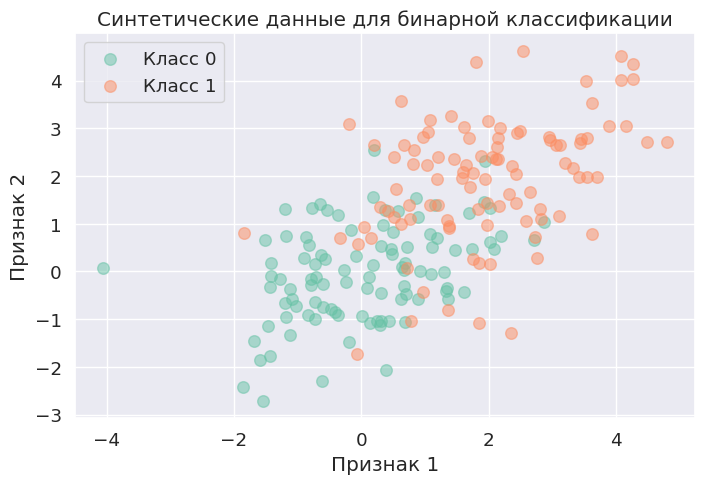

In [9]:
X, y = generate_intersecting_data(n_samples=200, random_state=42)
visualize_data(X, y)

Обучим модель логистической регрессии.

In [10]:
# Обучение модели
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

Введем функцию для визуализации предсказаний модели линейной регрессии.

In [11]:
def plot_decision_boundary(
    model: Any,
    X: np.ndarray,
    y: np.ndarray,
    figsize: Tuple[int, int] = (10, 6),
    title: str = "Предсказания модели линейной регрессии",
    xlabel: str = "Признак 1",
    ylabel: str = "Признак 2",
    cmap: str = "summer",
    colorbar_label: str = "Вероятность класса 1",
) -> None:
    """Визуализирует предсказание модели бинарной классификации.

    Параметры:
    model (Any): Обученная модель с методом predict_proba.
    X (np.ndarray): Матрица признаков (только первые два признака используются для визуализации).
    y (np.ndarray): Целевые метки.
    figsize (Tuple[int, int]): Размер графика (по умолчанию (10, 6)).
    title (str): Заголовок графика (по умолчанию "Предсказания модели линейной регрессии").
    xlabel (str): Подпись оси X (по умолчанию "Признак 1").
    ylabel (str): Подпись оси Y (по умолчанию "Признак 2").
    cmap (str): Цветовая схема (по умолчанию "summer").
    colorbar_label (str): Подпись цветовой шкалы (по умолчанию "Вероятность класса 1").
    """

    # Установка границ
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Создание сетки
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))

    # Предсказание вероятностей для сетки
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)

    # Построение графика
    plt.figure(figsize=figsize)
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=cmap, alpha=0.8)

    # Визуализация исходных точек
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=cmap, s=60, alpha=0.8)

    # Настройка оформления
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(False)
    plt.colorbar(label=colorbar_label)
    plt.show()

Визуализируем предсказанные вероятности классов

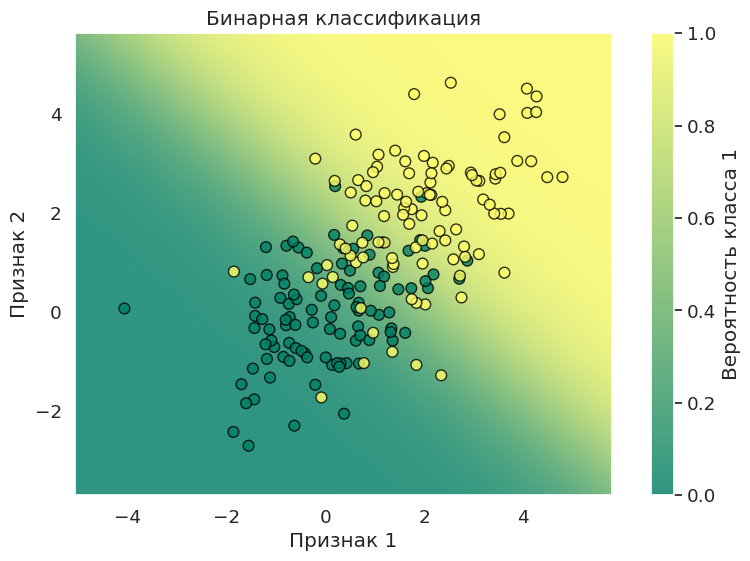

In [12]:
plot_decision_boundary(
    model, X, y, title="Бинарная классификация", xlabel="Признак 1", ylabel="Признак 2"
)

Видим, что предсказания более уверенные в тех областях, где есть только точки одного класса и менее уверенные на границе классов.

### 2. Реальные данные

#### 2.1. Постановка задачи логистической регрессии на реальных данных

Рассмотрим <a href="https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data" >данные</a> заболеваний сердца. В каждой строке представлены медицинские и другие показатели для каждого человека, а также наличие/отсутствие заболеваний сердца. 

**Задача:** предсказать *наличие/отсутствие патологии* по остальным признакам.



Несколько ключевых моментов, чем эта задача может быть полезна:

1. **Раннее выявление заболеваний:** система может помочь в идентификации пациентов с высоким риском развития сердечно-сосудистых заболеваний, что позволяет провести профилактику или раннее лечение, увеличивая шансы на успешное выздоровление.


2. **Снижение затрат на здравоохранение:** Предсказание может помочь снизить расходы на здравоохранение, позволяя сосредоточить ресурсы на более нуждающихся пациентах, что приводит к более эффективному использованию медицинских ресурсов.


3. **Персонализированная медицина:** Модель может способствовать персонализации медицинских рекомендаций, основываясь на уникальных признаках каждого пациента, что повышает качество обслуживания и удовлетворенность пациентов.


4. **Исследования и разработки:** Анализ данных позволяет выявлять новые паттерны и взаимосвязи, которые могут привести к новым научным открытиям и развитию новых методов лечения.



Ниже приведены описания некоторых признаков. Описание остальных признаков есть на  <a href="https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data" >сайте</a>

* `id`: уникальный идентификатор для каждого пациента;
* `age`: возраст пациента в годах;
* `sex`: пол;
* `cp`: тип боли в груди (типичная стенокардия, атипичная стенокардия, неангинальная, бессимптомная);

* `trestbps`: артериальное давление в покое (в мм рт. ст. при поступлении в больницу);
* `chol`: уровень холестерина в сыворотке крови (в мг/дл);
* `thalach`: максимальная достигнутая частота сердечных сокращений;
* `num`: целевой признак, категория заболевания;


Загрузим данные

In [13]:
data = pd.read_csv("heart_disease_uci.csv")
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Бинаризуем признак `num` и заполним пропуски.

In [14]:
data["num"] = data["num"] > 0
data.ffill(inplace=True)

Разделим данные на обучающие и тестовые.

In [15]:
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train.shape, test.shape

((736, 16), (184, 16))

#### 2.2. Обучение

Выделим группы признаков

In [16]:
categorial_features = [
    "sex",
    "dataset",
    "cp",
    "fbs",
    "restecg",
    "exang",
    "slope",
    "thal",
    "thal",
]  # категориальные признаки
real_features = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]  # вещественные признаки
target_feature = "num"  # целевой признак

Посмотрим на визуализацию совместных распределений вещественных признаков при помощи `PairGrid`, причем будем разбивать данные по одному признаку из числа категориальных. На графиках приведены:
* данные в виде точек для каждой пары вещественных признаков;
* ядерные оценки плотности для каждой пары вещественных признаков;
* ядерные оценки плотности для всех вещественных признаков по отдельности.

Подробнее про визуализацию можно почитать <a href="https://thetahat.ru/courses/python/07">в обучающих материалах</a> в разделах 3 и 6.

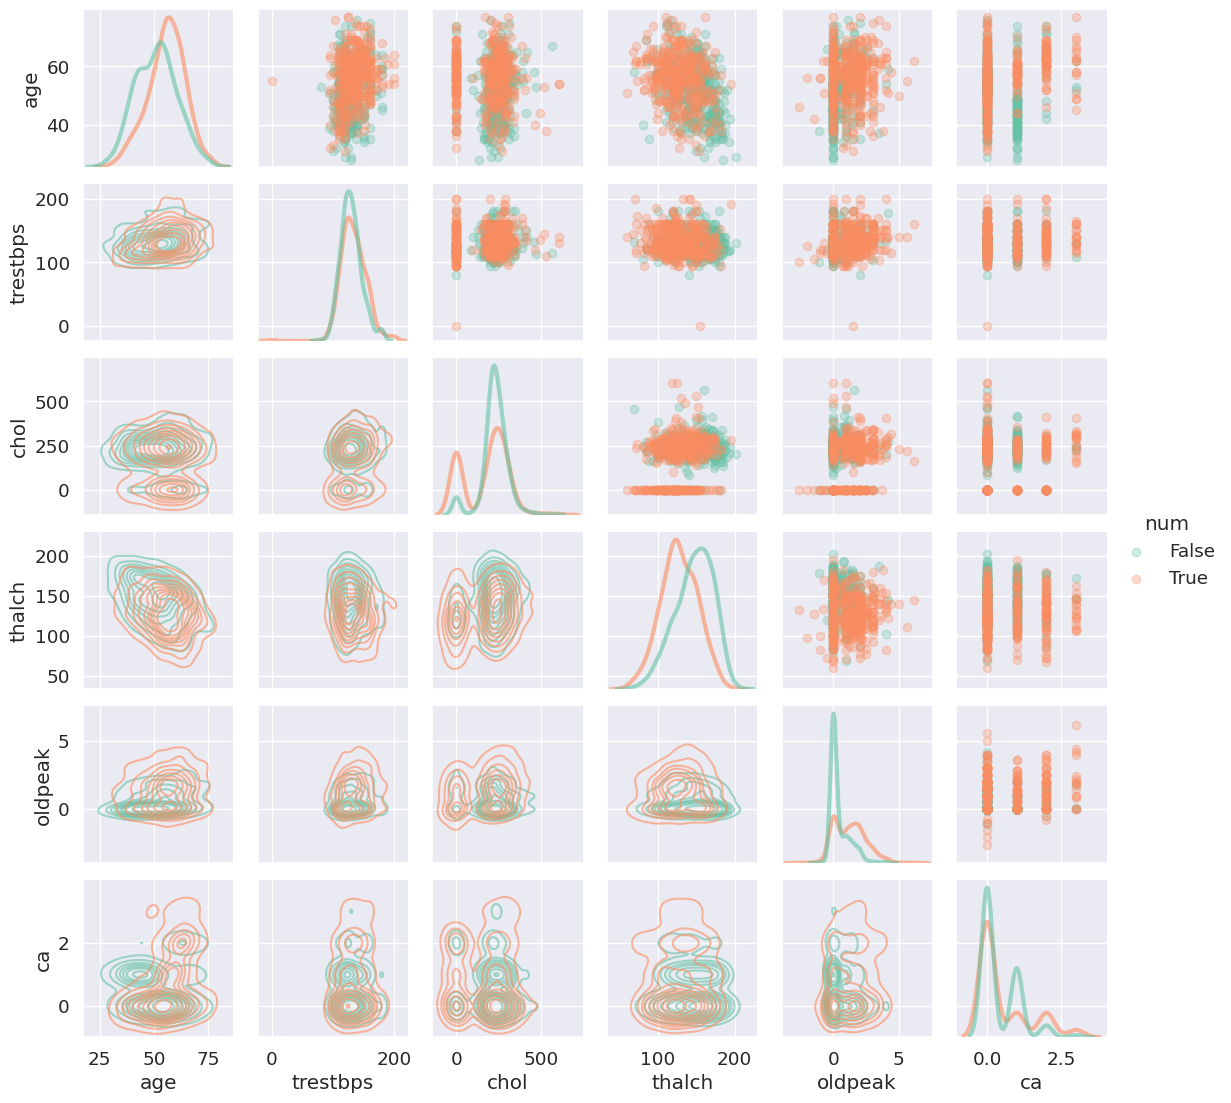

In [17]:
g = sns.PairGrid(
    train[real_features + [target_feature]], hue=target_feature, diag_sharey=False, height=3
)
g.fig.set_size_inches(11, 11)
g.map_lower(sns.kdeplot, alpha=0.6)
g.map_upper(plt.scatter, alpha=0.3)
g.map_diag(
    sns.kdeplot, lw=3, alpha=0.6, common_norm=False
)  # каждая плотность по отдельности должна давать 1 при интегрировании

g.add_legend();

По графикам сразу можно сделать следующие выводы:
* Люди с патологиями сердца в среднем имеют больший возраст, чем люди без патологий, что можно увидеть на графике с распределением возраста.
* Люди, достигавшие большую частоту сердцебиения, менее склонны к болезням сердца, что видно на графике с распределением максимальной частотой сердцения `thalach`.

Видимо, эти признаки должны оказать существенное влияние при построении регрессионной модели.

---
Закодируем категориальные признаки с помощью  <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">`OneHotEncoder`</a>.

In [18]:
encoder = OneHotEncoder(drop="first", sparse_output=False)  # объявляем модель
# Внимание! Нельзя вызывать fit_transform на тестовых данных!
train_cat = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_cat

array([[1., 0., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], shape=(736, 17))

Можем посмотреть на то, как у нас "обучились" категории. Для каждого категориального признака приведен список его категорий

In [19]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
       dtype=object),
 array(['asymptomatic', 'atypical angina', 'non-anginal', 'typical angina'],
       dtype=object),
 array([False, True], dtype=object),
 array(['lv hypertrophy', 'normal', 'st-t abnormality'], dtype=object),
 array([False, True], dtype=object),
 array(['downsloping', 'flat', 'upsloping'], dtype=object),
 array(['fixed defect', 'normal', 'reversable defect'], dtype=object),
 array(['fixed defect', 'normal', 'reversable defect'], dtype=object)]

Соединим вместе вещественные признаки и закодированные категориальные

In [20]:
X_train = np.hstack([train[real_features], train_cat])
X_train.shape

(736, 23)

После преобразования с помощью `OneHotEncoder` количество признаков увеличилось.

Наконец, **обучаем саму модель логистической регрессии** с помощью класса <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">`LogisticRegression`</a>.


Будем использовать методы `fit` и `predict` для логистической регрессии для бинарной классификации


In [21]:
model = LogisticRegression(max_iter=2000)  # объявляем модель
model.fit(X_train, train[target_feature])  # обучаем

LogisticRegression(max_iter=2000)

Посмотрим на оценки коэффициентов перед признаками.

In [22]:
feature_names = np.concatenate([real_features, encoder.get_feature_names_out()])

df_coefficients = pd.DataFrame(
    {
        "Feature": feature_names,
        "Coefficient": model.coef_.ravel(),  # Убедимся, что массив выровнен в одномерный
    }
)
df_coefficients

,Feature,Coefficient
0,age,0.006309
1,trestbps,0.001017
2,chol,0.000912
3,thalch,-0.005642
4,oldpeak,0.537259
5,ca,0.343457
6,sex_Male,1.171307
7,dataset_Hungary,-0.534431
8,dataset_Switzerland,2.472619
9,dataset_VA Long Beach,-0.168461


Оценка свободного коэффициента

In [23]:
model.intercept_

array([-1.15381723])

**Интерпретация значений коэффициентов**

1. **Знак коэффициента**
   - Положительный коэффициент указывает на то, что с увеличением значения признака шансы первого класса увеличиваются при прочих равных условиях.
   - Отрицательный коэффициент означает, что с увеличением значения признака шансы на положительный исход (первый признак) уменьшаются при прочих равных условиях.
2. **Значение коэффициента**
- Пусть для некоторого объекта полученные вероятности классов 0 и 1 соответственно равны $(1 - p_0)$ и $p_0$. Тогда для логита выполняется следующее соотношение
   $$
   \log\left(\frac{p_0}{1-p_0}\right) = \theta_0 + \theta_1  x_1 + \theta_2  x_2 + \ldots + \theta_i  x_i + \ldots + \theta_n  x_n
   $$
- Пусть $p_1$ &mdash; вероятность класса 1 при увеличении значения признака $x_j$ на 1 и неизменных значениях всех остальных признаков. Тогда соответствующий логит можно выразить следующим образом:
   $$
   \log\left(\frac{p_1}{1-p_1}\right) = \log\left(\frac{p_0}{1-p_0}\right) + \theta_j
   $$
  
Выразим отношения вероятностей
$$
\left. \frac{p_1}{1-p_1} \right/ \frac{p_0}{1-p_0} = \exp\left(\theta_j\right)
$$
    
Получаем следующий вывод **об интерпретации коэффициентов линейной регрессии**. При изменении признака $x_j$ на 1 и *фиксированных значениях остальных признаков* отношение вероятности класса 1 к вероятности класса 0 изменяется в $\exp\left(\theta_j\right)$ раз.

Данную интерпретацию можно упростить, если рассмотреть случай *малых значений* $p_0$ и $p_1$. В таком случае $1-p_0 \approx 1$ и $1-p_1 \approx 1$, соответственно получаем 
$$
\exp\left(\theta_j\right) \approx \frac{p_1}{p_0}.
$$
Тем самым, интерпретация упрощается: при изменении признака $x_j$ на 1 и *фиксированных значениях остальных признаков* вероятность класса 1 (если она мала) увеличивается примерно в $\exp\left(\theta_j\right)$ раз.

Людям с серьёзным техническим образованием может показаться странным такое упрощение. Однако на практике оказывается очень полезным объяснять полученные модели простыми словами. Этого часто требуют заказчики, которые хотят понимать принципы работы модели, но им сложно воспринимать сложные объяснения.

#### 2.3. Тестирование и оценка качества

Выполним теперь с тестовым множеством данные те же преобразования. Напомним еще раз, что некоторые преобразования можно было сделать со всеми данными, это было бы корректно. Однако во избежание ошибок в будущем рекомендуем определять преобразования только по обучающим данным, а затем применять их для тестовых.

In [24]:
# Кодируем категориальные признаки с помощью метода transform обученного ранее кодировщика
test_cat = encoder.transform(test[categorial_features])

# Соединяем данные
X_test = np.hstack([test[real_features], test_cat])

Выполним *предсказание* построенной ранее моделью с помощью метода `predict`

In [25]:
test_preds = model.predict(X_test)

Посчитать **ошибку предсказания** можно разными способами. Рассмотрим одну из основных метрик.




>**Точность (Accuracy)** \
>Точность определяет общую долю правильно классифицированных случаев:
>
> $$\text{Accuracy} =\frac{1}{n} \sum_{i=1}^{n} I\left\{Y_i = \widehat{Y}_i\right\}$$

Для сравнения посчитаем предсказания и ошибки на обучающем множестве.

In [26]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

Метрики на обучающем множестве

In [27]:
# Вычисляем точность
accuracy_score(train[target_feature], train_preds)

0.8491847826086957

Точность на тестовом множестве

In [28]:
accuracy_score(test[target_feature], test_preds)

0.8532608695652174

Видим, что точность на обучающем и тестовом множествах принимает близкие значения, качество классификации по этой метрике совпадает.